# GLASSY MODULUS

In [1]:
# import required packages

import traceback
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import (
    mean_absolute_percentage_error,
    mean_squared_error,
    mean_absolute_error,
)
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import layers
from keras.regularizers import l2
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem

### Data processing

In [2]:
# read data
filePath = r"C:\Users\Ama\OneDrive - Southern University System\01-Research\01-Data\01-Glassy_Modulus.csv"
df = pd.read_csv(filePath)

In [3]:
# Function to check if the number of SMILES corresponds to the number of entries in the ratio
def find_entries_with_difference(data):
    differing_entries = []


# Initialize an empty list to store differing entries
differing_entries = []

# Iterate through the DataFrame
for i, row in df.iterrows():
    smiles = row["Smiles"].split(",")
    ratios = row["Molar ratio"].split(":")

    # Check if the number of SMILES is different from the number of ratios
    if len(smiles) != len(ratios):
        differing_entries.append(
            (i + 1, row["SMPname"], row["Reference"], row["Smiles"], row["Molar Ratio"])
        )

# Print only the entries with differences
if differing_entries:
    print("Entries with differences in numbers of SMILES and ratios:")
    for line, SMPname, reference, smiles, ratio in differing_entries:
        print(f"Line {line}: {SMPname}-{reference}-{smiles} - {ratio}")
else:
    print("All entries have matching numbers of SMILES and ratios.")

All entries have matching numbers of SMILES and ratios.


In [4]:
# Initialize a list to store the line numbers with sums of ratios not equal to 1
lines_with_non_one_sums = []

# Iterate through the DataFrame
for i, row in df.iterrows():
    ratios = row["Molar ratio"].split(":")

    # Calculate the sum of ratios
    ratio_sum = sum(float(ratio) for ratio in ratios)

    # Check if the sum is not equal to 1
    if (
        abs(ratio_sum - 1.0) > 1e-6
    ):  # Use a small tolerance for floating-point comparison
        lines_with_non_one_sums.append(i + 1)  # Append line number to the list

# Check the result and print line numbers with sums of ratios not equal to 1
if not lines_with_non_one_sums:
    print("The sum of ratios is equal to 1 in all rows.")
else:
    print("Lines with sums of 'Molar ratio' not equal to 1:")
    for line in lines_with_non_one_sums:
        print(f"Line {line}: {df.loc[line-1, 'Molar ratio']}")

The sum of ratios is equal to 1 in all rows.


In [5]:
#
smiles = df["Smiles"]
smiles = [list(smile.strip("{} ").split(",")) for smile in smiles]

molar_ratio = df["Molar ratio"]
m_r = []
for entry in molar_ratio:
    ratio_list = [float(x) for x in entry.split(":")]
    m_r.append(ratio_list)

In [6]:
"""'
functions for fingerprinting and multiplication of
fingerprinted monomers by their respective molar ratios
"""


# function for storing fingerprints monomers as a representation of the polymers
def fingerprint_monomer(monomer):
    mol = Chem.MolFromSmiles(monomer)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 10, 1800)
    return fp


def fingerprint_polymer(polymer):
    polymer_fp = []
    for monomer in polymer:
        monomer_fp = fingerprint_monomer(monomer)
        polymer_fp.append(monomer_fp)
    return polymer_fp


def multiply_fingerprint(fp, m_r_value):
    return np.multiply(fp, m_r_value)


fingerprinted_polymer_data = []

for i, (polymer, polymer_m_r) in enumerate(zip(smiles, m_r)):
    try:
        fingerprinted_polymer = fingerprint_polymer(polymer)
        multiplied_polymer = [
            multiply_fingerprint(fp, m_r_value)
            for fp, m_r_value in zip(fingerprinted_polymer, polymer_m_r)
        ]
        fingerprinted_polymer_data.append(multiplied_polymer)
    except Exception as e:
        print(f"Error occurred at data point {i+1}")
        print(f"SMILES causing the error: {polymer}")
        traceback.print_exc()
# flatten the array created and storing them in a list
flattened_arr = [np.concatenate(arr) for arr in fingerprinted_polymer_data]

# find the maximum length of the flattened arrays
max_length = max(len(arr) for arr in flattened_arr)

# pad the arrays with zeros to make them the same length
padded_arrays = [
    np.pad(arr, (0, max_length - len(arr)), mode="constant") for arr in flattened_arr
]

new_array = np.stack(padded_arrays)

In [7]:
X = new_array
y = df["Glassy Modulus"]  # specify y

In [8]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=19, shuffle=True
)

# # Initialize the scaler
# scaler = StandardScaler()
# scaler.fit(X_train)

# # Fit the scaler on the training data and transform it
# X_train = scaler.transform(X_train)

# # Apply the same transformation to the test data
# X_test= scaler.transform(X_test)

# x_plot = np.linspace(0, 12)
# y_plot = x_plot

### ANN Model

Epoch 1/500
12/12 [==============================] - 7s 122ms/step - loss: 2.4552 - mape: 61.2640 - val_loss: 3.8052 - val_mape: 79.6477
Epoch 2/500
12/12 [==============================] - 1s 45ms/step - loss: 1.6658 - mape: 42.7523 - val_loss: 3.6967 - val_mape: 78.6212
Epoch 3/500
12/12 [==============================] - 0s 34ms/step - loss: 1.2465 - mape: 34.6656 - val_loss: 3.6037 - val_mape: 77.9782
Epoch 4/500
12/12 [==============================] - 0s 31ms/step - loss: 1.1925 - mape: 30.2461 - val_loss: 3.4535 - val_mape: 71.2465
Epoch 5/500
12/12 [==============================] - 0s 39ms/step - loss: 1.1457 - mape: 30.7654 - val_loss: 3.4431 - val_mape: 72.2945
Epoch 6/500
12/12 [==============================] - 0s 38ms/step - loss: 1.0590 - mape: 30.8489 - val_loss: 3.2217 - val_mape: 66.7942
Epoch 7/500
12/12 [==============================] - 0s 24ms/step - loss: 1.0181 - mape: 32.0845 - val_loss: 3.2519 - val_mape: 68.5072
Epoch 8/500
12/12 [============================

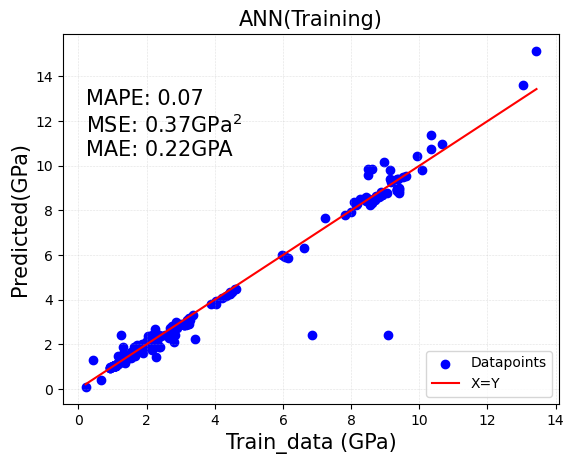

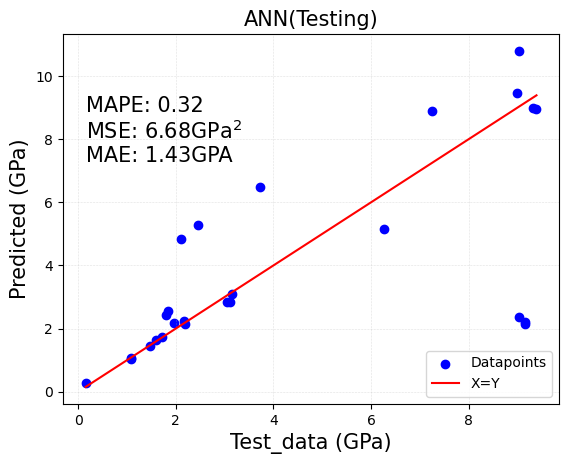

     y_test  y_test_pred
119   1.953     2.179071
149   1.079     1.060071
217   9.036     2.369223
193   1.477     1.440245
37    0.150     0.272851
216   9.146     2.211959
115   1.713     1.725407
132   2.159     2.230571
215   9.148     2.133876
205   1.087     1.042502
103   1.798     2.437636
98    6.262     5.164899
117   1.839     2.564076
214   8.982     9.467037
8     7.259     8.884966
213   9.028    10.798238
72    3.725     6.487748
224   9.318     8.989670
95    9.391     8.964127
176   3.050     2.857026
174   3.105     2.857044
163   3.149     3.079522
252   2.445     5.295506
121   2.185     2.153300
248   1.600     1.634352
1     2.100     4.847786


In [9]:
learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# Define the ANN model
model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation="relu", #kernel_regularizer=l2(0.01),
                              input_shape=(X_train.shape[1],)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1),
    ])

# Compile the model
model.compile(loss="mae", optimizer=optimizer, metrics=["mape"])

# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=500,
    batch_size=20,
    validation_data=(X_test, y_test),
    #callbacks=[mycallback],
)
# Predict on the test set
predicted_values = model.predict(X_test)


y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate the error
MAPE_train = mean_absolute_percentage_error(y_train, y_train_pred)
MAPE_test = mean_absolute_percentage_error(y_test, y_test_pred)

MSE_train = mean_squared_error(y_train, y_train_pred)
MSE_test = mean_squared_error(y_test, y_test_pred)

MAE_train = mean_absolute_error(y_train, y_train_pred)
MAE_test = mean_absolute_error(y_test, y_test_pred)


# Create a DataFrame to display y_test and y_test_pred
results_df = pd.DataFrame({'y_test': y_test, 'y_test_pred': y_test_pred.flatten()})

# Plot actual and predicted values for training set
plt.scatter(y_train, y_train_pred, color="b", label="Datapoints")
plt.plot(
    [min(y_train), max(y_train)], [min(y_train), max(y_train)], color="r", label="X=Y"
)
plt.xlabel("Train_data (GPa)", fontsize=15)
plt.ylabel("Predicted(GPa)", fontsize=15)
plt.text(
    min(y_train),
    max(y_train),
    f"MAPE: {MAPE_train:.2f}\nMSE: {MSE_train:.2f}GPa$^2$\nMAE: {MAE_train:.2f}GPA",
    ha="left",
    va="top",
    fontsize=15,
)
plt.grid(True, which="both", linestyle="dotted", linewidth=0.4, alpha=0.7)
plt.legend(loc="lower right")
plt.title("ANN(Training)", fontsize=15)
# plt.legend()
plt.show()

plt.scatter(y_test, y_test_pred, color="b", label="Datapoints")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="r", label="X=Y")
plt.xlabel("Test_data (GPa)", fontsize=15)
plt.ylabel("Predicted (GPa)", fontsize=15)
plt.text(
    min(y_test),
    max(y_test),
    f"MAPE: {MAPE_test:.2f}\nMSE: {MSE_test:.2f}GPa$^2$\nMAE: {MAE_test:.2f}GPA",
    ha="left",
    va="top",
    fontsize=15,
)
plt.grid(True, which="both", linestyle="dotted", linewidth=0.4, alpha=0.7)
plt.legend(loc="lower right")
plt.title("ANN(Testing)", fontsize=15)
# plt.legend()
plt.show()
print(results_df)

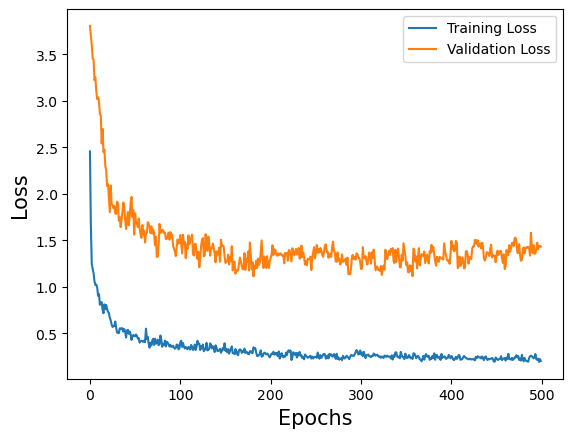

In [10]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.legend()
plt.show()

In [11]:
# results_df1 = pd.DataFrame({'y_train': y_train, 'y_train_pred': y_train_pred.flatten()})

# # Print the DataFrame
# print("Train Data and Predicted Values:")
# print(results_df1)
# results_df1.to_csv("Train_data.csv")

Epoch 1/500
81/81 [==============================] - 4s 22ms/step - loss: 1.7106 - mape: 44.4462 - val_loss: 0.9263 - val_mape: 33.0986
Epoch 2/500
81/81 [==============================] - 1s 14ms/step - loss: 0.8930 - mape: 24.9368 - val_loss: 0.6993 - val_mape: 30.0441
Epoch 3/500
81/81 [==============================] - 1s 16ms/step - loss: 0.6945 - mape: 19.4927 - val_loss: 0.6701 - val_mape: 28.6491
Epoch 4/500
81/81 [==============================] - 2s 24ms/step - loss: 0.6243 - mape: 17.7496 - val_loss: 0.5849 - val_mape: 28.6377
Epoch 5/500
81/81 [==============================] - 2s 25ms/step - loss: 0.5660 - mape: 16.8901 - val_loss: 0.5185 - val_mape: 20.5009
Epoch 6/500
81/81 [==============================] - 2s 25ms/step - loss: 0.4754 - mape: 14.5052 - val_loss: 0.5154 - val_mape: 28.7593
Epoch 7/500
81/81 [==============================] - 1s 15ms/step - loss: 0.4094 - mape: 12.9483 - val_loss: 0.4425 - val_mape: 19.5746
Epoch 8/500
81/81 [=============================

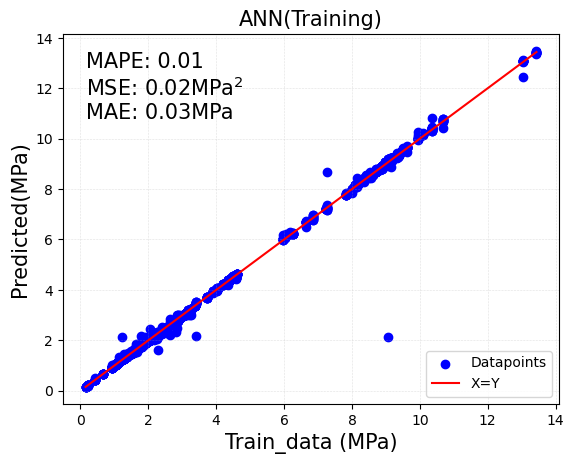

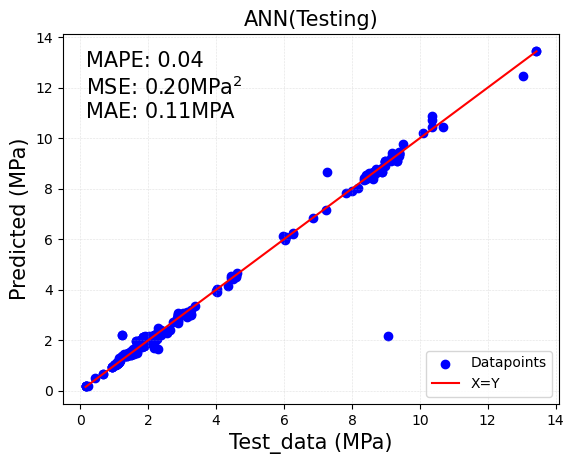

     y_test  y_test_pred
0    2.0060     1.970211
1    1.0830     1.080665
2    6.0700     6.099708
3    1.0845     1.083638
4    0.6600     0.676197
..      ...          ...
281  1.5000     1.531843
282  3.1490     3.120466
283  9.3400     9.100826
284  1.0800     1.103812
285  2.1720     1.708739

[286 rows x 2 columns]


In [12]:
# Define the data augmentation function
def augment_data(X, y, num_augmentations):
    augmented_X = []
    augmented_y = []

    for i in range(len(X)):
        augmented_X.append(X[i])
        augmented_y.append(y[i])

        for _ in range(num_augmentations):
            noise = np.random.normal(0, 0.01, X[i].shape)  # Adjust the noise level as needed
            augmented_sample = X[i] + noise
            augmented_X.append(augmented_sample)
            augmented_y.append(y[i])

    augmented_X = np.array(augmented_X)
    augmented_y = np.array(augmented_y)

    return augmented_X, augmented_y

num_augmentations = 10  # You can adjust this number as needed

# Perform data augmentation
augmented_X, augmented_y = augment_data(X, y, num_augmentations)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(augmented_X, augmented_y, test_size=0.1, random_state=42, shuffle=True)

learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# Define the ANN model
model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation="relu",
                              input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(1, activation="linear"),
    ])

# Compile the model
model.compile(loss="mae", optimizer=optimizer, metrics=["mape"])

# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=500,
    batch_size=32,
    validation_data=(X_test, y_test),
)
# Predict on the test set
predicted_values = model.predict(X_test)


y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate the error
MAPE_train = mean_absolute_percentage_error(y_train, y_train_pred)
MAPE_test = mean_absolute_percentage_error(y_test, y_test_pred)

MSE_train = mean_squared_error(y_train, y_train_pred)
MSE_test = mean_squared_error(y_test, y_test_pred)

MAE_train = mean_absolute_error(y_train, y_train_pred)
MAE_test = mean_absolute_error(y_test, y_test_pred)


# Create a DataFrame to display y_test and y_test_pred
results_df = pd.DataFrame({'y_test': y_test, 'y_test_pred': y_test_pred.flatten()})

# Plot actual and predicted values for training set
plt.scatter(y_train, y_train_pred, color="b", label="Datapoints")
plt.plot(
    [min(y_train), max(y_train)], [min(y_train), max(y_train)], color="r", label="X=Y"
)
plt.xlabel("Train_data (MPa)", fontsize=15)
plt.ylabel("Predicted(MPa)", fontsize=15)
plt.text(
    min(y_train),
    max(y_train),
    f"MAPE: {MAPE_train:.2f}\nMSE: {MSE_train:.2f}MPa$^2$\nMAE: {MAE_train:.2f}MPa",
    ha="left",
    va="top",
    fontsize=15,
)
plt.grid(True, which="both", linestyle="dotted", linewidth=0.4, alpha=0.7)
plt.legend(loc="lower right")
plt.title("ANN(Training)", fontsize=15)
# plt.legend()
plt.show()

plt.scatter(y_test, y_test_pred, color="b", label="Datapoints")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="r", label="X=Y")
plt.xlabel("Test_data (MPa)", fontsize=15)
plt.ylabel("Predicted (MPa)", fontsize=15)
plt.text(
    min(y_test),
    max(y_test_pred),
    f"MAPE: {MAPE_test:.2f}\nMSE: {MSE_test:.2f}MPa$^2$\nMAE: {MAE_test:.2f}MPA",
    ha="left",
    va="top",
    fontsize=15,
)
plt.grid(True, which="both", linestyle="dotted", linewidth=0.4, alpha=0.7)
plt.legend(loc="lower right")
plt.title("ANN(Testing)", fontsize=15)
# plt.legend()
plt.show()
print(results_df)

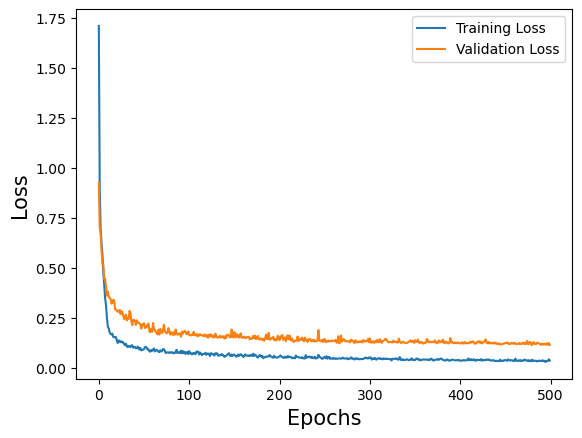

In [13]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.legend()
plt.show()